In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

In [42]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.datasets import make_multilabel_classification

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import RandomSampling, UncertaintySampling
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

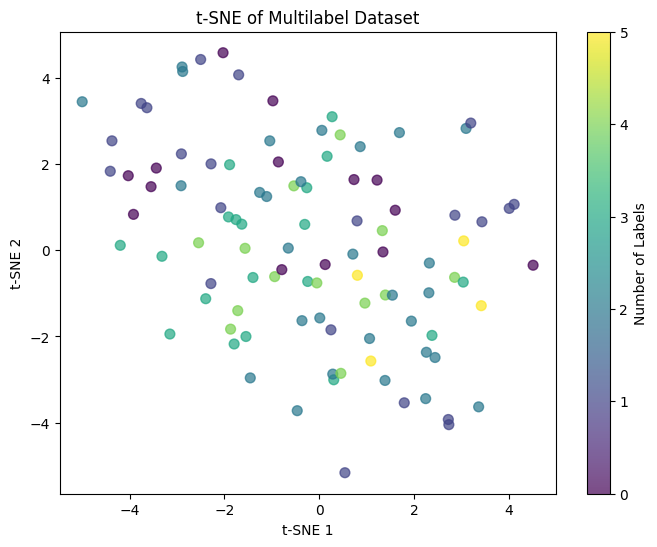

In [70]:
X, y_true = make_multilabel_classification(n_samples=100,
                                      n_features=20,
                                      n_classes=5,
                                      n_labels=2,
                                      random_state=0)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
bound = [[min(X_tsne[:, 0]), min(X_tsne[:, 1])], [max(X_tsne[:, 0]), max(X_tsne[:, 1])]]
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.sum(y_true, axis=1), cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label="Number of Labels")
plt.title("t-SNE of Multilabel Dataset")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [5]:
y = np.full(shape=y_true.shape[0], fill_value=MISSING_LABEL)
print(y)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


In [55]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import MetaEstimatorMixin, is_classifier
from sklearn.utils.validation import has_fit_parameter, check_is_fitted, check_array

from skactiveml.base import SkactivemlClassifier
from skactiveml.utils import match_signature, is_labeled
from copy import deepcopy

In [56]:
class SklearnMultiOutputClassifier(SkactivemlClassifier, MetaEstimatorMixin):
    def __init__(
        self,
        estimator,
        classes=None,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=None,
    ):
        super().__init__(
            classes=classes,
            missing_label=missing_label,
            cost_matrix=cost_matrix,
            random_state=random_state,
        )
        self.estimator = estimator

    @match_signature("estimator", "fit")
    def fit(self, X, Y, sample_weight=None, **fit_kwargs):
        return self._fit(
            fit_function="fit",
            X=X,
            Y=Y,
            sample_weight=sample_weight,
            **fit_kwargs,
        )
    
    @match_signature("estimator", "predict_proba")
    def predict_proba(self, X, **predict_proba_kwargs):
        """Return probability estimates for the input data X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Input samples.
        predict_proba_kwargs : dict-like
            Further parameters as input to the 'predict_proba' method of the
            'estimator'.

        Returns
        -------
        P : array-like, shape (n_samples, classes)
            The class probabilities of the input samples. Classes are ordered
            by lexicographic order.
        """
        check_is_fitted(self)
        X = check_array(X, **self.check_X_dict_)
        self._check_n_features(X, reset=False)
        if self.is_fitted_:
            P = self.estimator_.predict_proba(X, **predict_proba_kwargs)
            # map the predicted classes to self.classes
            if P.shape[1] != len(self.classes_):
                P_ext = np.zeros((len(X), len(self.classes_)))
                est_classes = self.estimator_.classes_
                indices_est = np.where(np.isin(est_classes, self.classes_))[0]
                class_indices = np.searchsorted(
                    self.classes_, est_classes[indices_est]
                )
                P_ext[:, class_indices] = 1 if len(class_indices) == 1 else P
                P = P_ext
            if not np.any(np.isnan(P)):
                return P

        warnings.warn(
            f"Since the 'base_estimator' could not be fitted when"
            f" calling the `fit` method, the class label "
            f"distribution`_label_counts={self._label_counts}` is used to "
            f"make the predictions."
        )
        if sum(self._label_counts) == 0:
            return np.ones([len(X), len(self.classes_)]) / len(self.classes_)
        else:
            return np.tile(
                self._label_counts / np.sum(self._label_counts), [len(X), 1]
            )
    
    def _fit(self, fit_function, X, Y, sample_weight=None, **fit_kwargs):
        # Check input parameters.
        self.check_X_dict_ = {
            "ensure_min_samples": 0,
            "ensure_min_features": 0,
            "allow_nd": True,
            "dtype": None,
        }
        X, y, sample_weight = self._validate_data(
            X=X,
            y=Y,
            sample_weight=sample_weight,
            check_X_dict=self.check_X_dict_,
            y_ensure_1d=False
        )

        # Check whether estimator is a valid classifier.
        if not is_classifier(estimator=self.estimator):
            raise TypeError(
                "'{}' must be a scikit-learn "
                "classifier.".format(self.estimator)
            )

        # Check whether estimator can deal with cost matrix.
        if self.cost_matrix is not None and not hasattr(
            self.estimator, "predict_proba"
        ):
            raise ValueError(
                "'cost_matrix' can be only set, if 'estimator'"
                "implements 'predict_proba'."
            )
        if fit_function == "fit" or not hasattr(self, "n_features_in_"):
            self._check_n_features(X, reset=True)
        elif fit_function == "partial_fit":
            self._check_n_features(X, reset=False)
        if hasattr(self, "estimator_"):
            if fit_function != "partial_fit":
                self.estimator_ = deepcopy(self.estimator)
        else:
            self.estimator_ = deepcopy(self.estimator)
            
        # count labels per class
        is_lbld = is_labeled(y, missing_label=-1)
        self._label_counts = [
            np.sum(y[is_lbld] == c) for c in range(len(self._le.classes_))
        ]
        try:
            X_lbld = X[is_lbld]
            y_lbld = y[is_lbld].astype(np.int64)
            y_lbld_inv = self._le.inverse_transform(y_lbld)
            if np.sum(is_lbld) == 0:
                raise ValueError("There is no labeled data.")
            elif (
                not has_fit_parameter(self.estimator, "sample_weight")
                or sample_weight is None
            ):
                if fit_function == "partial_fit":
                    fit_kwargs["classes"] = self.classes_
                    self.estimator_.partial_fit(
                        X=X_lbld, y=y_lbld_inv, **fit_kwargs
                    )
                elif fit_function == "fit":
                    self.estimator_.fit(X=X_lbld, y=y_lbld_inv, **fit_kwargs)
            else:
                if fit_function == "partial_fit":
                    fit_kwargs["classes"] = self.classes_
                    fit_kwargs["sample_weight"] = sample_weight[is_lbld]
                    self.estimator_.partial_fit(
                        X=X_lbld,
                        y=y_lbld_inv,
                        **fit_kwargs,
                    )
                elif fit_function == "fit":
                    fit_kwargs["sample_weight"] = sample_weight[is_lbld]
                    self.estimator_.fit(
                        X=X_lbld,
                        y=y_lbld_inv,
                        **fit_kwargs,
                    )
            self.is_fitted_ = True
        except Exception as e:
            self.is_fitted_ = False
            warnings.warn(
                "The 'base_estimator' could not be fitted because of"
                " '{}'. Therefore, the class labels of the samples "
                "are counted and will be used to make predictions. "
                "The class label distribution is `_label_counts={}`.".format(
                    e, self._label_counts
                )
            )
        return self
    

In [57]:
clf = SklearnMultiOutputClassifier(
    MultiOutputClassifier(LogisticRegression()),
    classes=np.arange(y_true.shape[1]))

In [119]:
from skactiveml.utils import is_unlabeled, simple_batch
from sklearn.utils import column_or_1d


class RandomSamplingMultilabel():
    def _validate_data(
        self,
        X,
        y,
        candidates,
        batch_size,
        return_utilities,
        reset=True,
        check_X_dict=None,
    ):
        #X, y, candidates, batch_size, return_utilities = super()._validate_data(
        #    X, y, candidates, batch_size, return_utilities, reset, check_X_dict
        #)
        #y = column_or_1d(y, warn=True)
        self.missing_label_ = MISSING_LABEL
        if candidates is None:
            n_candidates = int(
                np.sum(is_unlabeled(y, missing_label=self.missing_label_))
            )
        else:
            n_candidates = len(candidates)

        if n_candidates < batch_size:
            warnings.warn(
                f"'batch_size={batch_size}' is larger than number of "
                f"candidates. Instead, 'batch_size={n_candidates}' was set."
            )
            batch_size = n_candidates

        return X, y, candidates, batch_size, return_utilities
    
    def query(
        self, X, y, candidates=None, batch_size=1, return_utilities=False
    ):
        X, y, candidates, batch_size, return_utilities = self._validate_data(
            X, y, candidates, batch_size, return_utilities, reset=True
        )
        
        self.random_state_ = self.random_state
        X_cand, mapping = self._transform_candidates(candidates, X, y)

        if mapping is None:
            utilities = np.ones(len(X_cand))
        else:
            utilities = np.full(len(X), np.nan)
            utilities[mapping] = np.ones(mapping.shape)
        
        return simple_batch(
            utilities,
            self.random_state_,
            batch_size=batch_size,
            return_utilities=return_utilities,
            method="proportional",
        )

In [120]:
qs = UncertaintySampling(method='entropy', random_state=42)
qs = RandomSamplingMultilabel(random_state=42)


In [121]:
n_cycles = 20
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
y_2 = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf.fit(X, y_2)
for c in range(n_cycles):
    query_idx, utilities = qs.query(X=X, y=y, batch_size=1, return_utilities=True)
    y_2[query_idx] = y_true[query_idx]
    y[query_idx] = 1
    clf.fit(X, y_2)

    # plotting
    # unlbld_idx = unlabeled_indices(y_2)
    # lbld_idx = labeled_indices(y_2)
    # if len(lbld_idx) in [2, 10, 20]:
    #     print(f'After {len(lbld_idx)} iterations:')
        #print(f'The accuracy score is {clf.score(X,y_true)}.')
        #plot_utilities(qs, X=X, y=y, clf=clf, feature_bound=bound)
        # plot_decision_boundary(clf, feature_bound=bound)
        # X_tsne = tsne.fit_transform(X)
        # plt.scatter(X_tsne[unlbld_idx,0], X_tsne[unlbld_idx,1], c='gray')
        # plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='jet')
        # plt.show()